In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [60]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [61]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [62]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=10
latent_dimensions=16

num=4000
comps=2

beta=0.1

In [63]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp\ipykernel_9748\834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [64]:
blends_max=np.amax(blended)
blends_min=np.amin(blended)
comp_max=np.amax(components)
comp_min=np.amin(components)

blended-=blends_min
blended/=blends_max
components-=comp_min
components/=comp_max

blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

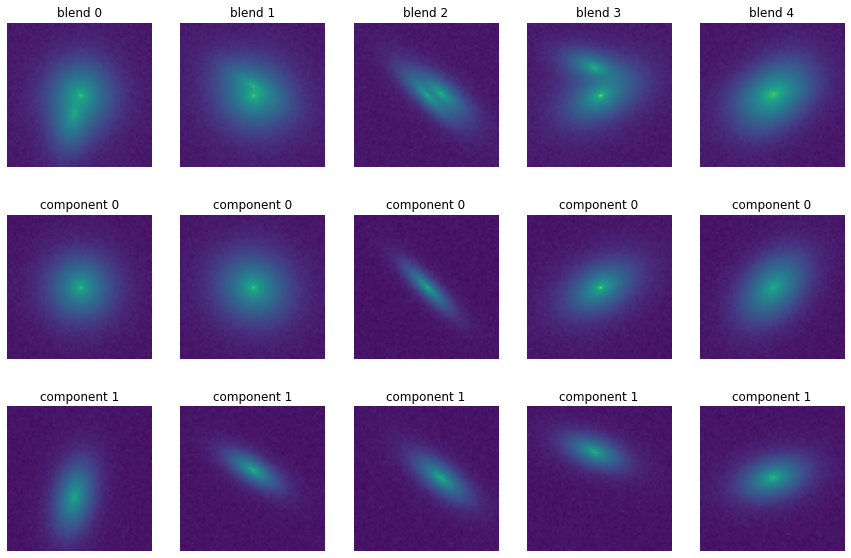

In [65]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [66]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [67]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [68]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [69]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [70]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_17[0][0]                  
______________________________________________________________________________________

In [71]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_25 (Functional)   (None, 16)                73216     
_________________________________________________________________
functional_27 (Functional)   (None, 64, 64, 1)         106209    
Total params: 179,425
Trainable params: 179,425
Non-trainable params: 0
_________________________________________________________________


In [72]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [73]:
history=vae.fit(components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 10s 26ms/step - loss: 6.5061 - mse_loss: 6.4516 - kl_loss: 0.0545 - val_loss: 1.1641 - val_mse_loss: 1.1000 - val_kl_loss: 0.0641
Epoch 2/100
360/360 [==============================] - 9s 25ms/step - loss: 0.8278 - mse_loss: 0.7696 - kl_loss: 0.0582 - val_loss: 0.6565 - val_mse_loss: 0.6036 - val_kl_loss: 0.0529
Epoch 3/100
360/360 [==============================] - 10s 27ms/step - loss: 0.6550 - mse_loss: 0.6055 - kl_loss: 0.0495 - val_loss: 0.5794 - val_mse_loss: 0.5329 - val_kl_loss: 0.0465
Epoch 4/100
360/360 [==============================] - 9s 26ms/step - loss: 0.5955 - mse_loss: 0.5515 - kl_loss: 0.0440 - val_loss: 0.5883 - val_mse_loss: 0.5451 - val_kl_loss: 0.0432
Epoch 5/100
360/360 [==============================] - 9s 25ms/step - loss: 0.5373 - mse_loss: 0.4966 - kl_loss: 0.0407 - val_loss: 0.5216 - val_mse_loss: 0.4819 - val_kl_loss: 0.0397
Epoch 6/100
360/360 [==============================] - 9s 25ms/step - loss: 0.

360/360 [==============================] - 9s 26ms/step - loss: 0.4397 - mse_loss: 0.4162 - kl_loss: 0.0235 - val_loss: 0.4325 - val_mse_loss: 0.4095 - val_kl_loss: 0.0231
Epoch 46/100
360/360 [==============================] - 10s 27ms/step - loss: 0.4325 - mse_loss: 0.4095 - kl_loss: 0.0230 - val_loss: 0.4235 - val_mse_loss: 0.4008 - val_kl_loss: 0.0227
Epoch 47/100
360/360 [==============================] - 9s 26ms/step - loss: 0.4474 - mse_loss: 0.4246 - kl_loss: 0.0229 - val_loss: 0.4512 - val_mse_loss: 0.4283 - val_kl_loss: 0.0228
Epoch 48/100
360/360 [==============================] - 10s 27ms/step - loss: 0.4259 - mse_loss: 0.4031 - kl_loss: 0.0227 - val_loss: 0.4263 - val_mse_loss: 0.4040 - val_kl_loss: 0.0223
Epoch 49/100
360/360 [==============================] - 10s 27ms/step - loss: 0.4412 - mse_loss: 0.4187 - kl_loss: 0.0225 - val_loss: 0.4283 - val_mse_loss: 0.4061 - val_kl_loss: 0.0222
Epoch 50/100
360/360 [==============================] - 9s 25ms/step - loss: 0.4273 -

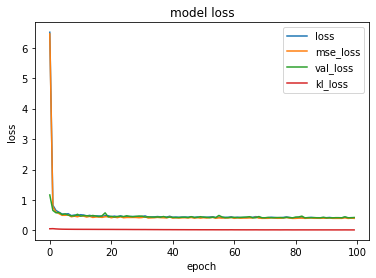

In [74]:
loss_plot(history)

In [75]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


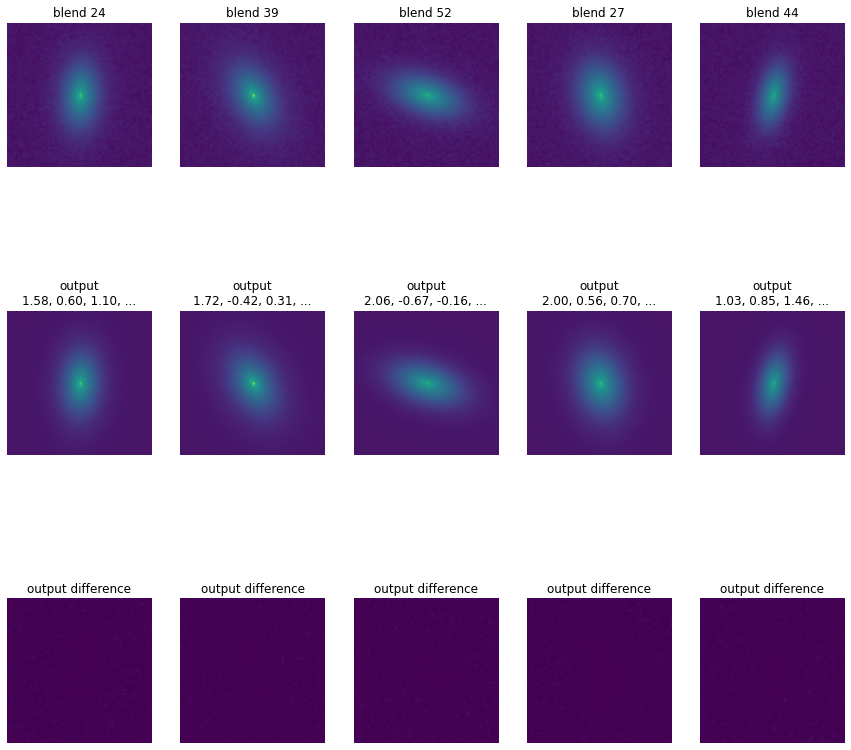

In [76]:
chosen=summary_plot(n,components[0],decode)

In [77]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [78]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode=Model([input_embed,input_compc],[output1])
decode.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_21[0][0]                  
______________________________________________________________________________________

In [79]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2,input_compc])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_31 (Functional)      (None, 16)           73216       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_33 (Functional)      (None, 64, 64, 1)    106209      functional_31[0][0]              
                                                                 input_12[0][0]       

In [80]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [81]:
history=vae.fit(together,verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 8s 22ms/step - loss: 5.5136 - mse_loss: 5.4959 - kl_loss: 0.0177 - val_loss: 3.8498 - val_mse_loss: 3.8294 - val_kl_loss: 0.0204
Epoch 2/100
360/360 [==============================] - 7s 21ms/step - loss: 3.0936 - mse_loss: 3.0732 - kl_loss: 0.0204 - val_loss: 2.7139 - val_mse_loss: 2.6925 - val_kl_loss: 0.0214
Epoch 3/100
360/360 [==============================] - 7s 21ms/step - loss: 2.5101 - mse_loss: 2.4893 - kl_loss: 0.0208 - val_loss: 2.2400 - val_mse_loss: 2.2180 - val_kl_loss: 0.0220
Epoch 4/100
360/360 [==============================] - 8s 21ms/step - loss: 2.1841 - mse_loss: 2.1625 - kl_loss: 0.0216 - val_loss: 2.1451 - val_mse_loss: 2.1244 - val_kl_loss: 0.0207
Epoch 5/100
360/360 [==============================] - 8s 22ms/step - loss: 1.9083 - mse_loss: 1.8874 - kl_loss: 0.0209 - val_loss: 1.8638 - val_mse_loss: 1.8423 - val_kl_loss: 0.0215
Epoch 6/100
360/360 [==============================] - 8s 23ms/step - loss: 1.73

360/360 [==============================] - 8s 22ms/step - loss: 0.5959 - mse_loss: 0.5773 - kl_loss: 0.0185 - val_loss: 1.0062 - val_mse_loss: 0.9887 - val_kl_loss: 0.0176
Epoch 88/100
360/360 [==============================] - 8s 21ms/step - loss: 0.5995 - mse_loss: 0.5807 - kl_loss: 0.0188 - val_loss: 0.9978 - val_mse_loss: 0.9786 - val_kl_loss: 0.0192
Epoch 89/100
360/360 [==============================] - 8s 21ms/step - loss: 0.5977 - mse_loss: 0.5793 - kl_loss: 0.0184 - val_loss: 1.0016 - val_mse_loss: 0.9835 - val_kl_loss: 0.0181
Epoch 90/100
360/360 [==============================] - 8s 22ms/step - loss: 0.5989 - mse_loss: 0.5803 - kl_loss: 0.0186 - val_loss: 0.9678 - val_mse_loss: 0.9493 - val_kl_loss: 0.0185
Epoch 91/100
360/360 [==============================] - 8s 21ms/step - loss: 0.6044 - mse_loss: 0.5861 - kl_loss: 0.0184 - val_loss: 0.9638 - val_mse_loss: 0.9451 - val_kl_loss: 0.0187
Epoch 92/100
360/360 [==============================] - 8s 22ms/step - loss: 0.5947 - ms

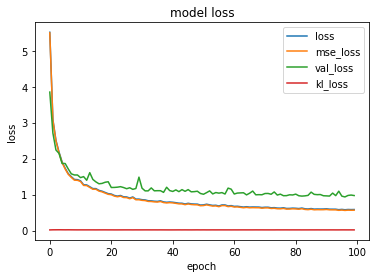

In [82]:
loss_plot(history)

In [83]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode2.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')
    return idx

[ 200 1078  610 2159 1169]


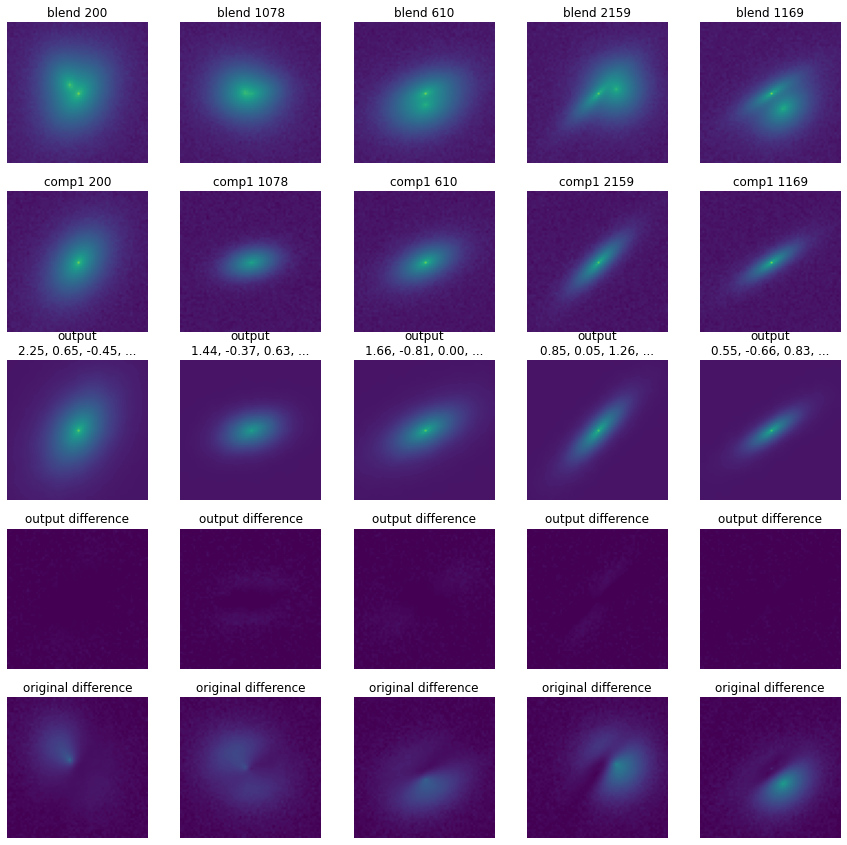

In [84]:
chosen=summary_plot(n,together,decode)

(Text(0.5, 0, 'Loss'), Text(0, 0.5, 'Frequency'))

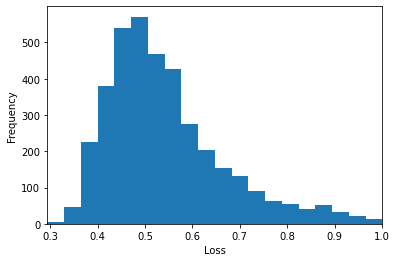

In [85]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=0,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
loss_max=np.amax(losses)
loss_min=np.amin(losses)
ax=plt.axes()
ax.hist(losses,bins=500)
ax.set_xlim(max(loss_min,0),min(loss_max,1)),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")

In [86]:
#vae.save_weights("model_1.h5")
#decode.save_weights("decoder_1.h5")

In [87]:
#vae=Model.load_weights("model_1.h5")
#vae.summary()